# Final Project - Planned Transitway Traffic Prediction
This notebook takes historical AADT data, Minnesota road segments, future and existing transit lines, and bus routes to train a XGBRegressor model. The model is trained on traffic before and after an existing transit line is opened and predicts how traffic will change after a planned transit line is constructed. Assistance for this code was provided by ChatGPT. 

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt

In [3]:
#Ignore warnings for this notebook
warnings.filterwarnings('ignore')

## Prepare and clean data
This section reads the transitway, bus route, historical AADT, and road segment data. It then cleans up this data and joins them together for use in the model. 

#### Merge road segment geometry with historical traffic data
This code reads the traffic segment shapefile with geometry and merges it with the historical traffic data. This is a key step to attach AADT to geometry. 

In [70]:
# Load the traffic segments shapefile (with geometry)
# Data was obtained from Minnesota Geospatial Commons
gdf_traffic_segments = gpd.read_file('Annual_Average_Daily_Traffic_Segments_in_Minnesota.shp')

# Load the historic traffic CSV 
# Data was obtained from Minnesota Geospatial Commons
gdf_historic_traffic = pd.read_csv('historic_AADT_mn.csv')

# Join the traffic segments with the historical traffic data on road segment number
gdf_merged = gdf_traffic_segments.merge(gdf_historic_traffic, on='SEQUENCE_N', how='left')

# Save the merged result as a new shapefile for further analysis
gdf_merged.to_file('merged_road_data.shp')

#### Rewrite table so each road segment is listed once
This code rewrites the data, so that instead of each road segment have a seperate row for each year it has data, each road segment has several colums representing the years. This is important to keep the data organized, especially later in the code when merging with transitways. 

In [32]:
# Load the merged road data
road_gdf = gpd.read_file('merged_road_data.shp')

# Save the geometry for later (gets lost when reworking the table)
geometry = road_gdf.geometry

# Pivot the dataframe, so each segment is only listed once and each year gets a column
pivot_df = road_gdf.drop(columns='geometry').pivot_table(index='SEQUENCE_N', columns='DATA_YEAR', values='AADT', aggfunc='first')

# Reattach the columns needed for later analysis
pivot_df['ROUTE_LABE'] = road_gdf.groupby('SEQUENCE_N')['ROUTE_LABE'].first().values
pivot_df['AXLE_FACTO'] = road_gdf.groupby('SEQUENCE_N')['AXLE_FACTO'].first().values

# Reattach the geometry
pivot_df['geometry'] = road_gdf.groupby('SEQUENCE_N')['geometry'].first().values

# Convert back to geodataframe
pivot_gdf = gpd.GeoDataFrame(pivot_df, geometry='geometry', crs=road_gdf.crs)

# Convert all column names to strings (numerical years can mess it up)
pivot_gdf.columns = pivot_gdf.columns.astype(str)

# Reset index
pivot_gdf = pivot_gdf.reset_index()

# Save the result to a new shapefile
pivot_gdf.to_file('cleaned_road_data.shp')

#### Fill in missing values by averaging out or taking adjacent
This code fills in missing null values in historical AADT data. This finds the average of the two surrounding year's data or takes the value of the year before or after. This helps to eliminate small gaps in data that could confuse the model. This is a simple method to tackle this as  gaps are rare in recent years, which is when most routes opened.  

In [33]:
# Load the shapefile into a geodataframe
roads_gdf = gpd.read_file('cleaned_road_data.shp')

# Save the geometry column to preserve it
geometry_data = roads_gdf.geometry

# List of columns to exclude from filling missing values
exclude_columns = ['ROUTE_LABE', 'AXLE_FACTO', 'SEQUENCE_N', 'geometry']

# Extract the list of years
years = [col for col in roads_gdf.columns if col.isdigit() and col not in exclude_columns]

# Sort year columns
years.sort()

# Iterate through all rows in the road geodataframe
for row, aadt in roads_gdf.iterrows():
    # Iterate through the year columns for this row
    for column_number, year in enumerate(years):
        current_value = aadt[year]
        # Check if the current value is null
        if pd.isna(current_value):
            # Get the previous and next values from the same row
            prev_value = roads_gdf.at[row, years[column_number - 1]] if column_number > 0 else None 
            next_value = roads_gdf.at[row, years[column_number + 1]] if column_number < len(years) - 1 else None
            # If both surrounding values are not null, average them
            if pd.notna(prev_value) and pd.notna(next_value):
                roads_gdf.at[row, year] = (prev_value + next_value) / 2
            # If only one surrounding value is not null, fill with that value
            elif pd.notna(prev_value):
                roads_gdf.at[row, year] = prev_value
            elif pd.notna(next_value):
                roads_gdf.at[row, year] = next_value

# Reassign the geometry column back to the geodataframe
roads_gdf.geometry = geometry_data

# Save the result to a new shapefile
roads_gdf.to_file('filled_road_data.shp')

#### Prepare Transitway Data and Merge with Bus Data
This code merges the transitway data, which includes major transit lines like light rail, commuter, rail or bus rapid transit, with standard bus routes. This code also cleans up the data to only include existing or planned transitways, and bus routes with known opening dates. The code renames the bus route columns to match the transitway data and merges them into one dataframe. 

In [34]:
# Load transitway routes and bus routes
transitways_gdf = gpd.read_file('TransitwayAlignmentsGeneralized.shp')
bus_gdf = gpd.read_file('bus_routes.shp')

# Filter out the transitways to only existing or planned
cleaned_transitways_gdf = transitways_gdf[(transitways_gdf['Transitway'] == 'Existing') | (transitways_gdf['Transitway'] == 'Planned')]

# Exclude the commuter rail, which mainly aligns with highways and messes up model
cleaned_transitways_gdf = cleaned_transitways_gdf[cleaned_transitways_gdf['Mode'] != 'Commuter Rail']

# Filter out to bus routes that have known opening dates
bus_years_gdf = bus_gdf[bus_gdf['Opened'] > 0]

# Save the newly filtered data (for quality control)
cleaned_transitways_gdf.to_file('transitways.shp')
bus_years_gdf.to_file('bus_routes_years.shp')

# Make a copy of the bus routes geodataframe
bus_years_updates_gdf = bus_years_gdf.copy()

# Rename the columns in the bus routes to match the columns in transitways dataset
bus_years_updates_gdf = bus_years_updates_gdf.rename(columns={
    'route': 'NameTransi',
    'Opened': 'LastOffi_1',
    'Class': 'Mode'
})

# Add a column to the bus routes to specify the routes are existing
bus_years_updates_gdf['Transitway'] = 'Existing' 

# Drop name column (not needed)
bus_years_updates_gdf = bus_years_updates_gdf.drop('Name', axis=1)

# Append the bus routes data to the transitways data
combined_gdf = pd.concat([cleaned_transitways_gdf, bus_years_updates_gdf], ignore_index=True)

# Save the resulting geodataframe to a new shapefile
combined_gdf.to_file('combined_transit_routes.shp')

#### Join Roadways with Transit Routes
This code performs a spatial join to combine the transit route data with the roadway data. A buffer of 100 meters was selected to account for any misalignment of routes, or roads very close to transit lines. This spatial join gives each roadway the information of transitways near it. If multiple transitways, there will be duplicate roadways to help train the model. 

In [71]:
# Load transit and roads files
transit_gdf = gpd.read_file('combined_transit_routes.shp')
roads_gdf = gpd.read_file('filled_road_data.shp')

# Create a buffer around the transitways to capture relevant routes
transit_gdf['geometry'] = transit_gdf.geometry.buffer(100) 

# Spatial join to associate roads with transitways
transit_roads_gdf = gpd.sjoin(
    roads_gdf, 
    transit_gdf, 
    how='left', 
    predicate='intersects'
)

# Save joined data
transit_roads_gdf.to_file('transit_roads_join.shp')

## Set up features for model
This section creates columns to be used as features in the model and performs any last-minute fixes on the data before use in the model. 

#### Create traffic difference and 4 year average columns
This code takes the combined transit and road data and drops older years, as they have lots of nulls that can mess up the model. It then calculates year-to-year differences in AADT, as well as a 4-year rolling average of AADT. The differences were selected as a way to train the model how traffic changes from year to year, the rollin averages were to help inform the model of traffic trends. 

In [36]:
# Load combined transitway and road data
transit_roads_gdf = gpd.read_file("transit_roads_join.shp")

# Years to exclude, as most segments do not have values and confuses model 
exclude_years = ['1985', '1987', '1989', '1991', '1992', '1993', '1994', '1995', '1996', '1997']

# Columns to exclude when calculating differences and averages
exclude_columns = ['ROUTE_LABE', 'AXLE_FACTO', 'SEQUENCE_N', 'geometry']

# Extract the list of year columns, excluding the years we don't want
years = [col for col in transit_roads_gdf.columns if col.isdigit() and col not in exclude_columns + exclude_years]

# Drop the columns that are in the list
transit_roads_gdf.drop(columns=exclude_years, inplace=True)

# Create year-to-year differences
for i in range(len(years) - 1): 
    transit_roads_gdf[f'diff_{years[i]}'] = transit_roads_gdf[f'{years[i+1]}'] - transit_roads_gdf[f'{years[i]}']

# Create 4 year rolling averages
for i in range(len(years) - 3):  # For each year (excluding last 2 years)
    transit_roads_gdf[f'4avg_{years[i]}'] = transit_roads_gdf[[f'{years[i]}', f'{years[i+1]}', f'{years[i+2]}',f'{years[i+3]}']].mean(axis=1)

# Save these new calculations to file
transit_roads_gdf.to_file('aadt_transit_features.shp')

#### Final tweaks for model
This code performs final adjustments needed before the data goes into the model. The code fills the opening year columns for any roads without transit at 9999, to inform the model they have no opening year. The code also gives planned routes an opening year of 2024, as that is the year after the most recent data. 

In [4]:
# Load the prepared data
final_data = gpd.read_file("aadt_transit_features.shp")

# Fill missing transitway years with a placeholder value (9999 for no transitway)
final_data['LastOffi_1'] = final_data['LastOffi_1'].fillna('9999')

# Set LastOffi_1 to 2024 for roads marked as 'Planned' in the Transitway column
final_data.loc[final_data['Transitway'] == 'Planned', 'LastOffi_1'] = '2024'

## Set up and run model
This section of the code trains the model and runs it off of the prepared data. 

#### Function to prepare data with features and targets
This is the vital part of the code. The function sets up all the features and targets for the model. It takes the year-to-year differences, 4-year averages, transit type and road type to train the model. The model considers all roads, even those without any transit to learn generalized trends. The model then uses polyfit to identify trends before and after the construction of transit. This is then used to predict the differences in traffic between years. The end of this block of code runs the function and gets it ready to be run through the model. 

In [5]:
def prepare_data_with_slope(data):
    """
    Prepares features and targets, calculates the slope of the trend before and after the target year.
    Predicts the change in AADT between years.
    """

    # Empty lists to store features, targets, and columns
    features = []
    targets = []
    feature_columns = []

    # One hot encode 'Mode' and 'AXLE_FACTO' columns, as they are categorical
    data_encoded = pd.get_dummies(data, columns=['Mode', 'AXLE_FACTO'], prefix=['Mode', 'Axle'])

    # Loop through feature columns to build features list
    for index, row in data_encoded.iterrows():
        # Get year transit opened
        year = int(row['LastOffi_1'])
        # Flag for transitway versus non-transitway road 
        transitway = year != '9999'

        # Collect feature columns
        diff_columns = [col for col in data_encoded.columns if col.startswith("diff_")]
        avg4_columns = [col for col in data_encoded.columns if col.startswith("4avg_")]
        mode_columns = [col for col in data_encoded.columns if col.startswith("Mode_")]
        axle_columns = [col for col in data_encoded.columns if col.startswith("Axle_")]
        aadt_columns = [col for col in data_encoded.columns if col.isdigit()] 

        # Build list of feature columns
        feature_columns = diff_columns + avg4_columns + mode_columns + axle_columns + aadt_columns

        # Build the feature row
        feature_row = row[feature_columns].values.tolist()
        
        # Add transitway flag 
        feature_row.append(transitway)
        
        # Set the target as None (for non-transitway roads)
        target = None

        # Calculate target for transitway roads
        if transitway:
            if year != '2024':
                # Find the years before and after transitway opened
                pre_years = [int(col.split('_')[1]) for col in diff_columns if int(col.split("_")[1]) < year]
                post_years = [int(col.split('_')[1]) for col in diff_columns if int(col.split("_")[1]) >= year]
                
                # Find the traffic volume difference for years before and after opening 
                pre_values = [row[col] for col in diff_columns if int(col.split("_")[1]) < year]
                post_values = [row[col] for col in diff_columns if int(col.split("_")[1]) >= year]

                # Remove non-numeric data (any nulls or other)
                pre_values = [v for v in pre_values if isinstance(v, (int, float)) and not np.isnan(v)]
                post_values = [v for v in post_values if isinstance(v, (int, float)) and not np.isnan(v)]

                # If there are values before and after, use poly fit to find the slope of change before and after
                # Offer the best model performance, rather than just using differences
                if len(pre_values) > 1 and len(post_values) > 1:
                    pre_trend = np.polyfit(pre_years[:len(pre_values)], pre_values, 1)[0]
                    post_trend = np.polyfit(post_years[:len(post_values)], post_values, 1)[0]
                    target = post_trend - pre_trend
        else:
            # Placeholder for the trend for non-transitway roads
            feature_row.append(None)

        # Append processed feature row and target to list
        features.append(feature_row)
        targets.append(target)

    # Filter out any null values in case
    features = [features[i] for i in range(len(features)) if targets[i] is not None]
    targets = [t for t in targets if t is not None]

    # Save feature column names for use in prediction
    np.save("feature_columns.npy", feature_columns)
    return features, targets, feature_columns

In [6]:
# Run the function and prepare the model 
features, targets, feature_columns = prepare_data_with_slope(final_data)

#### Run XGBRegressor Model with Best Parameters from Randomized Search
This code uses all of the components set up in the previous code blocks. The data is split into training and test data and ideal parameters are selected. These parameters were selected using randomized search, which can be seen at the end of the code, as it is not part of the actual workflow. The model is trained and then predicts based on test data. The output shows the model's performance. With an R-squared of 0.614103805404373, the model has an average performance that goes beyond just guessing averages. 

In [7]:
# Create arrays for features and targets for use in the model 
X = np.array(features)
y = np.array(targets)

# Remove the last column as it is blank and breaks the prediction
X = X[:, :-1] 

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load feature columns
feature_columns = np.load("feature_columns.npy", allow_pickle=True)

# Best parameter dictionary generated by Randomized Search to find best params (see end of code)
best_params = {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 1.0, 'colsample_bytree': 0.9}

# Train the model using best parameters and run XGBRegressor
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    n_jobs=-1
)
# Fit model to training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 779706.4858193847
R-squared: 0.614103805404373
Root Mean Squared Error: 883.009901314467


## Make predictions and get results
This section uses the trained model to make predictions for planned transitways. It also evaluates the predicted change compared to known data to evaluate if the model predicts the planned transitways will significantly increase or decrease traffic. 

#### Use model to predict change in traffic (percent change and AADT change)
This code uses the trained model to make predictions of traffic changes after implementing planned transitways. The model predicts the change in AADT. The code matches the columns used in the training section to allow for its use in predicting. After predicting, the predicted AADT is calculated, as well as the percent change in traffic. 

In [8]:
# Get road segments of planned transitways
planned_rows = final_data[final_data['LastOffi_1'] == '2024']

# Apply one-hot encoding to the planned data to match the training data
planned_rows_encoded = pd.get_dummies(planned_rows, columns=['Mode', 'AXLE_FACTO'], prefix=['Mode', 'Axle'])

# Reorder columns to match training columns order
missing_columns = set(feature_columns) - set(planned_rows_encoded.columns)
# Add any missing columns to match training data
for col in missing_columns:
    planned_rows_encoded[col] = 0 

# Ensure the column order matches the feature_columns
planned_rows_encoded = planned_rows_encoded[feature_columns]

# Make predictions for the planned transitway roads
X_planned = planned_rows_encoded
planned_predictions = model.predict(X_planned)

# Put the predictions back into the original geodataframe
final_data.loc[final_data['LastOffi_1'] == '2024', 'traffic_change'] = planned_predictions

# Calculate the predicted AADT for 2024
final_data['predicted_aadt'] = final_data['2023'] + final_data['traffic_change']

# Calculate the percent change in traffic for 2024
final_data['percent_change'] = ((final_data['predicted_aadt'] - final_data['2023']) / final_data['2023']) * 100

# Save the updated data to a new file
final_data.to_file("predicted_traffic_changes.shp")

#### Calculate results for analysis
The following code finds the average percent changes for roads without transitways, with existing transitways, and with planned transitways. It also finds the average predicted percent change in traffic for each planned transitway. The end of this code shows a comparison of the average traffic changes for roadways before 2024 to compare to the average predicted percent change for roads with planned transitways. The results show a slightly smaller traffic increase for roads with planned transitways than other roads, but not a reduction. This is not surprising, as the roads with planned transitways already had a smaller percent increase in traffic than other roads in the real data. 

In [9]:
def calculate_avg_change(data, years):
    """Function to calculate average 3 year change in traffic for comparison"""
    # Calculate the percent changes for consecutive years
    change_2021_2022 = (data[years[1]] - data[years[0]]) / data[years[0]] * 100
    change_2022_2023 = (data[years[2]] - data[years[1]]) / data[years[1]] * 100
    # Average the two percent changes
    return (change_2021_2022 + change_2022_2023) / 2

In [10]:
# Define the three years to calculate
years = ['2021', '2022', '2023']

# Filter the datasets
non_transitway_data = final_data[final_data['LastOffi_1'] == '9999']
existing_transitway_data = final_data[(final_data['LastOffi_1'] != '9999') & (final_data['LastOffi_1'] != '2024')]
planned_transit_data = final_data[final_data['LastOffi_1'] == '2024']

# Calculate 3-year average percent changes
non_transitway_data['non_transit_change_avg'] = calculate_avg_change(non_transitway_data, years)
existing_transitway_data['transit_change_avg'] = calculate_avg_change(existing_transitway_data, years)
planned_transit_data['planned_change_avg'] = calculate_avg_change(planned_transit_data, years)

# Get the overall averages for each group
none_percent_change_avg = non_transitway_data['non_transit_change_avg'].mean()
existing_percent_change_avg = existing_transitway_data['transit_change_avg'].mean()
planned_percent_change_avg = planned_transit_data['planned_change_avg'].mean()
future_planned_change = final_data['percent_change'].mean()
individual = planned_transit_data.groupby('NameTransi')['percent_change'].mean()

# Print results
print(f"3-Year Average percent change (2021-2023) in traffic (for roads without transitways): {none_percent_change_avg:.2f}%")
print(f"3-Year Average percent change (2021-2023) in traffic (for roads with existing transitways): {existing_percent_change_avg:.2f}%")
print(f"3-Year Average percent change (2021-2023) in traffic (roads with planned transitways): {planned_percent_change_avg:.2f}%")
print(f"2-Year Average percent change (2023-2024) in traffic (roads with planned transitways implemented): {future_planned_change:.2f}%")
print(f"Average Percent Traffic Change (2023-2024) for each planned transitway: {individual.to_string(float_format="%.2f")}")

3-Year Average percent change (2021-2023) in traffic (for roads without transitways): 5.94%
3-Year Average percent change (2021-2023) in traffic (for roads with existing transitways): 3.63%
3-Year Average percent change (2021-2023) in traffic (roads with planned transitways): 3.68%
2-Year Average percent change (2023-2024) in traffic (roads with planned transitways implemented): 2.09%
Average Percent Traffic Change (2023-2024) for each planned transitway: NameTransi
B Line                   2.96
Blue Line Extension      3.28
E Line                   9.36
F Line                   5.99
G Line                  -3.32
Gold Line                0.26
Green Line Extension   -16.76
Purple Line             -8.39
Riverview               17.54


#### Visualize predicted percent change in traffic
The following creates a map of predicted traffic change for user visualization and to better understand the predictions. The darker green segments have a larger percent decrease in traffic, while the darker red shows a larger percent increase in traffic from 2023 to 2024. The visualization shows how different areas show different changes in traffic. 

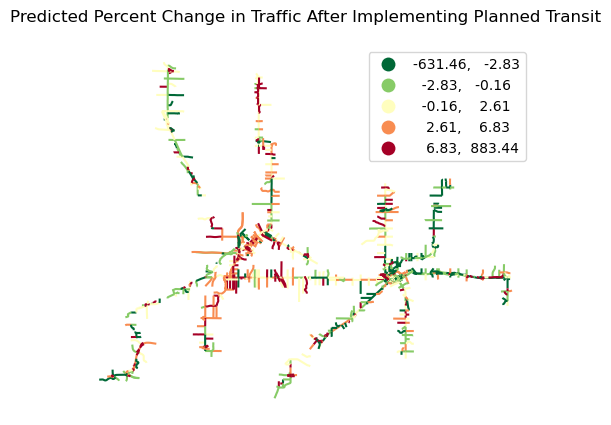

In [11]:
planned_transit_data.plot(column='percent_change', cmap='RdYlGn_r', scheme="quantiles", legend=True)
plt.title("Predicted Percent Change in Traffic After Implementing Planned Transit")
plt.axis("off")
plt.show()

#### Visualize predicted changes in graphs
The following creates two bar charts, one for overall percent changes in traffic, and another for individual transitways. This is another way to visualize the results. 

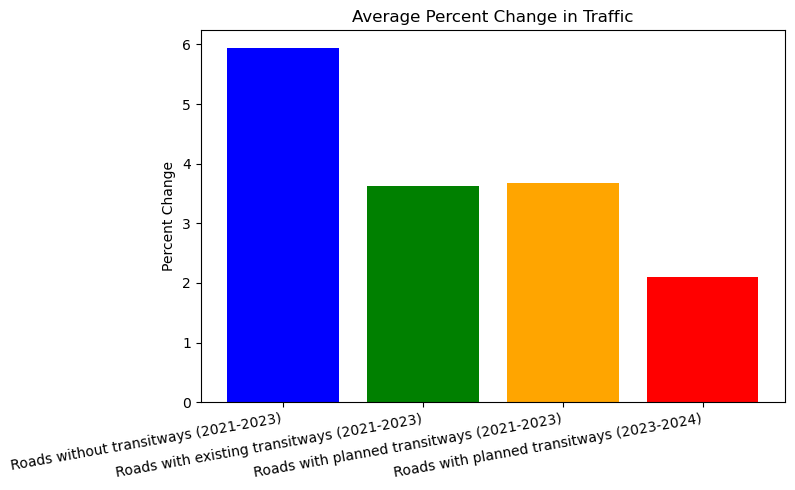

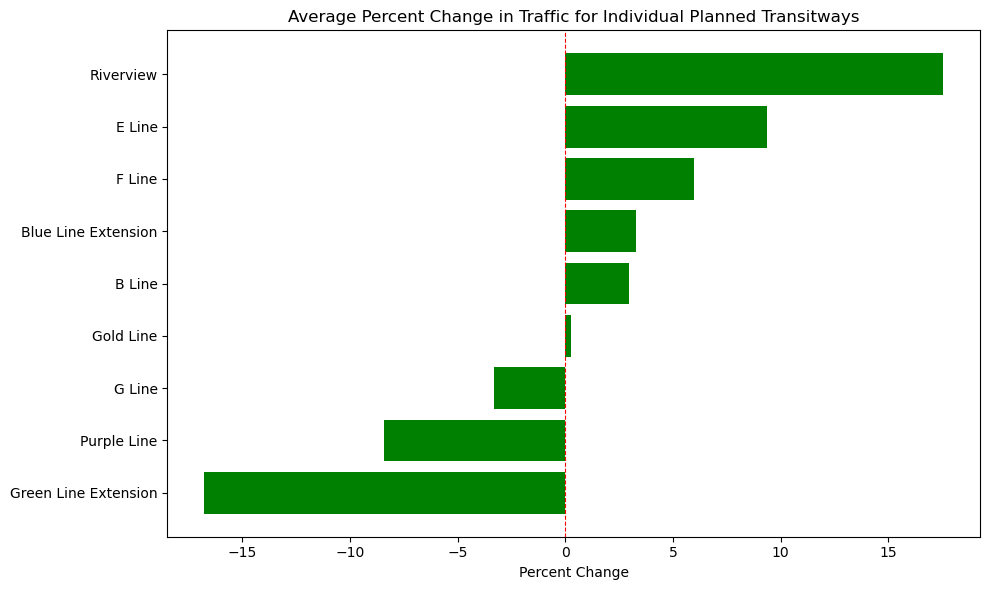

In [ ]:
# Variables
categories = ['Roads without transitways (2021-2023)', 'Roads with existing transitways (2021-2023)', 'Roads with planned transitways (2021-2023)', 'Roads with planned transitways (2023-2024)']
three_year_changes = [none_percent_change_avg, existing_percent_change_avg, planned_percent_change_avg, future_planned_change]
two_year_change = [future_planned_change]

# Planned transitways data, sort for better visualization
individual_changes = individual.sort_values()

# Overall Average Percent Change
plt.figure(figsize=(8, 5))
plt.bar(categories, three_year_changes, color=['blue', 'green', 'orange', 'red'])
plt.title('Average Percent Change in Traffic')
plt.ylabel('Percent Change')
plt.xticks(rotation=10, ha='right')
plt.tight_layout()
plt.show()

# Average Percent Traffic Change for Planned Transitways
plt.figure(figsize=(10, 6))
plt.barh(individual_changes.index, individual_changes.values, color='green')
plt.title('Average Percent Change in Traffic for Individual Planned Transitways')
plt.xlabel('Percent Change')
plt.axvline(0, color='red', linestyle='--', linewidth=0.8)  # Highlight zero line
plt.tight_layout()
plt.show()

#### Randomized Search to find best parameters
This portion of the code is not needed for the workflow, but was originally used to find the best parameters for
the XGBRegressor model

In [ ]:
# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)

# Define the hyperparameter grid (with a wider range for Randomized Search)
param_dist = {
    'learning_rate': np.linspace(0.01, 0.1, 10),
    'max_depth': [3, 6, 10, 12],
    'n_estimators': [100, 200, 500, 1000],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1.0],
    'min_child_weight': [1, 5, 10, 20]
}

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

# Get the best hyperparameters
print("Best Params:", random_search.best_params_)

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the best model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")